In [1]:
%matplotlib inline
%run ../../path_import.py
import numpy as np
import matplotlib.pyplot as plt
from plots import *
from utils import *
from training_os import *
from model_mu_reparam import *
import time
import probtorch
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.1.0 cuda: True


In [2]:
Data = torch.from_numpy(np.load('../rings_fixed_radius/obs.npy')).float()
## Data Parameters
N = 300
K = 3
D = 2
FIXED_RADIUS = 1.5
## Model Parameters
MCMC_SIZE = 10
SAMPLE_SIZE = 10
NUM_HIDDEN_GLOBAL = 16
NUM_HIDDEN_LOCAL = 64
STAT_SIZE = 8
NUM_LATENTS =  D
## Training Parameters
BATCH_SIZE = 20
NUM_EPOCHS = 1000
LEARNING_RATE =  5 * 1e-4
CUDA = torch.cuda.is_available()
PATH = 'ag-os-%dsteps-%dsamples' % (MCMC_SIZE, SAMPLE_SIZE)
DEVICE = torch.device('cuda:1')

In [3]:
enc_mu = Enc_mu(K, D, num_hidden=NUM_HIDDEN_GLOBAL, num_stats=STAT_SIZE, CUDA=CUDA, device=DEVICE)
enc_z = Gibbs_z(K, CUDA, DEVICE)
oneshot_mu = Oneshot_mu(K, D, num_hidden=NUM_HIDDEN_GLOBAL, num_stats=STAT_SIZE, CUDA=CUDA, device=DEVICE)
obs_rad = torch.ones(1) * FIXED_RADIUS
noise_sigma = torch.ones(1) * 0.05
if CUDA:
    enc_mu.cuda().to(DEVICE)
    oneshot_mu.cuda().to(DEVICE)
    obs_rad = obs_rad.cuda().to(DEVICE)
    noise_sigma =noise_sigma.cuda().to(DEVICE)
optimizer =  torch.optim.Adam(list(oneshot_mu.parameters())+list(enc_mu.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))

In [4]:
# enc_mu.load_state_dict(torch.load("../weights/enc-mu-%s" % PATH))
# oneshot_mu.load_state_dict(torch.load("../weights/oneshot-mu-%s" % PATH))

In [5]:
RESAMPLE=True
DETACH=True
train_mu(Eubo_cfz_os_eta, oneshot_mu, enc_mu, enc_z, optimizer, Data, obs_rad, noise_sigma, K, NUM_EPOCHS, MCMC_SIZE, SAMPLE_SIZE, BATCH_SIZE, PATH, CUDA, DEVICE, RESAMPLE=RESAMPLE, DETACH=DETACH)

epoch=0, SymKL=268967.324, EUBO=-1416435.964, ELBO=-4375076.447, ESS=1.004 (12s)
epoch=1, SymKL=111372.476, EUBO=-1567585.801, ELBO=-2792683.000, ESS=1.004 (10s)
epoch=2, SymKL=45436.892, EUBO=-1660161.641, ELBO=-2159967.430, ESS=1.004 (11s)
epoch=3, SymKL=21718.683, EUBO=-1604248.086, ELBO=-1843153.613, ESS=1.007 (12s)
epoch=4, SymKL=12969.385, EUBO=-1534458.839, ELBO=-1677122.056, ESS=1.008 (12s)
epoch=5, SymKL=8597.052, EUBO=-1500240.998, ELBO=-1594808.567, ESS=1.010 (12s)
epoch=6, SymKL=5872.037, EUBO=-1476730.424, ELBO=-1541322.823, ESS=1.014 (12s)
epoch=7, SymKL=4036.648, EUBO=-1466326.912, ELBO=-1510730.039, ESS=1.018 (12s)
epoch=8, SymKL=2750.081, EUBO=-1451601.326, ELBO=-1481852.208, ESS=1.024 (10s)
epoch=9, SymKL=1877.789, EUBO=-1441803.904, ELBO=-1462459.587, ESS=1.032 (10s)
epoch=10, SymKL=1299.180, EUBO=-1433080.847, ELBO=-1447371.825, ESS=1.044 (11s)
epoch=11, SymKL=951.877, EUBO=-1440463.569, ELBO=-1450934.221, ESS=1.057 (12s)
epoch=12, SymKL=733.781, EUBO=-1446112.105, 

KeyboardInterrupt: 

In [ ]:
torch.save(enc_mu.state_dict(), "../weights/enc-mu-%s" % PATH)
torch.save(oneshot_mu.state_dict(), "../weights/oneshot-mu-%s" % PATH)

CPU times: user 2.97 s, sys: 7.55 ms, total: 2.98 s
Wall time: 2.55 s


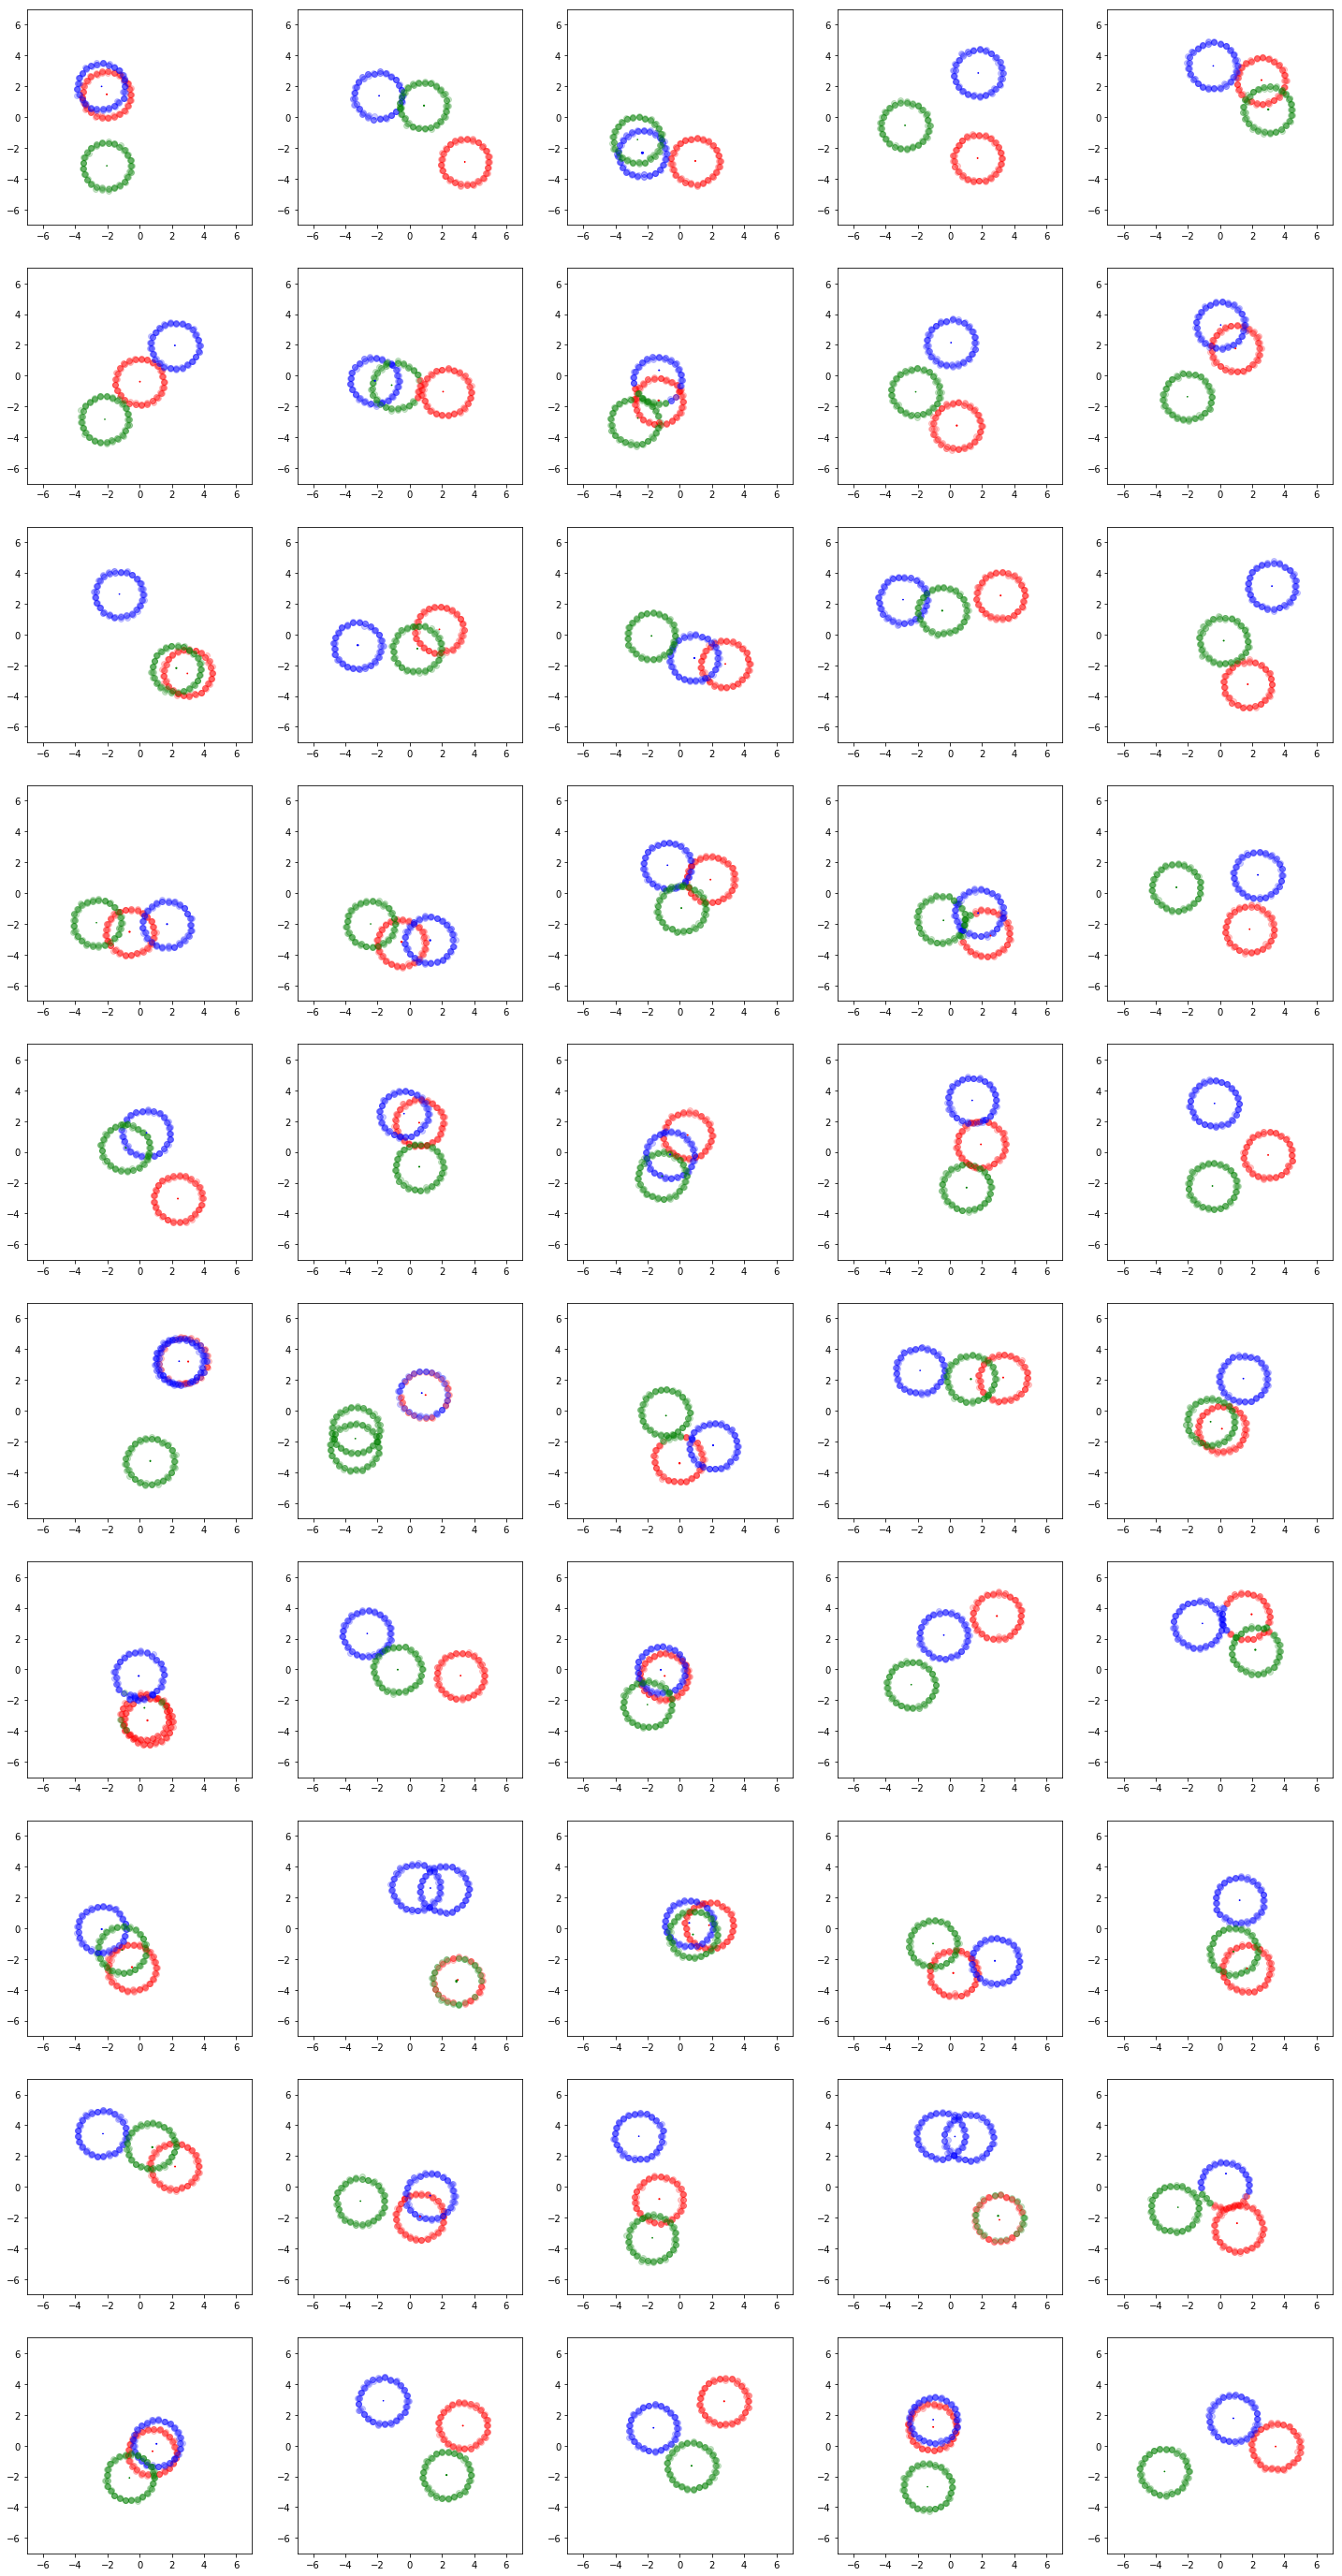

In [6]:
BATCH_SIZE_TEST = 50
RESAMPLE=True
DETACH=True
obs, q_mu, q_z, symkls_test, eubos_test, elbos_test = test(Eubo_cfz_os_eta, oneshot_mu, enc_mu, enc_z, Data, obs_rad, noise_sigma, K, 10, SAMPLE_SIZE, BATCH_SIZE_TEST, CUDA, DEVICE, RESAMPLE, DETACH=DETACH)
%time plot_samples(obs, q_mu, q_z, K, PATH)

In [7]:
incremental_gap = symkls_test.cpu().data.numpy()[1:]
M = incremental_gap.shape[0]
overall_gap = np.zeros(M)
for m in range(M):
    overall_gap[m] = incremental_gap[:m+1].sum()

Text(0.5, 0, 'Steps')

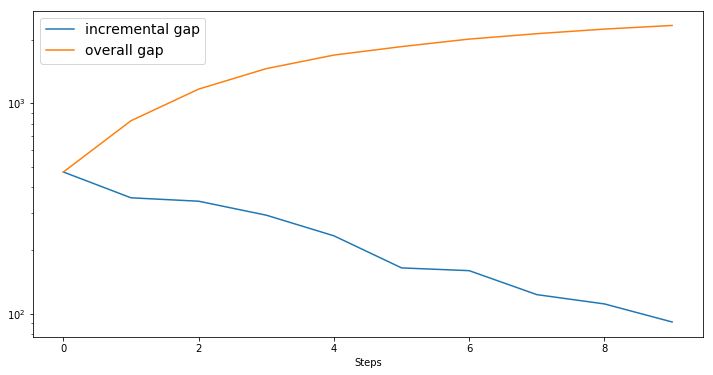

In [8]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.yscale("log")
ax.plot(incremental_gap, label="incremental gap")
ax.plot(overall_gap, label='overall gap')
ax.legend(fontsize=14)
ax.set_xlabel('Steps')